#  Targeting volume

There are two strqtegies that aim at executing a number of shares equivalent to a fraction of 
- (i) the rate at which other participants are sending MOs : Percentage of volume : POV
- (ii) the total volume that has been traded over the entire time horizon : Percentage of cumulative volume : POCV

The rate and the total volume  quantities are connected because total volume is the sum over the rate of trading, but the optimal execution strategy could be quite different in both cases. One simple approach to  targeting (i) is to observe the volume traded over the last seconds or minutes. Obviously this approach is not optimal because it does not adress the problem of market impact when the agent's order amalgamate with other orders. Targeting (ii)  is difficult because it is not possible to know ahead the volume. Moreover, neither are compatible with the objective of acquisition or liquidation of an order in full by the end of the trading horizon because there is no guarantee that the sum of the fractions of volume traded will add up to the number of shares that the agent set out to acquire or liquidate.

The VWAP benchmark VWAP ($T_{1},T_{2}$) = $\frac{\int_{T_{1}}^{T_{2}}S_{t}dV_{t}}{\int_{T_{1}}^{T_{2}}dV_{t}}$

One way to target VWAP is to follow strategy (i) because targeting a fraction of the rate of trading at every instant in time ensures that the investor is tracking the average price. Ideally, if the investor's strategy smoothes the execution of the number of shares he wishes to execute over the planned time horizon and at the same time adamantly targets a fixed proportion of the rate at which other market participants are trading, then the average cost of the shares he execute will be close to VWAP. An important source of risk when targeting POV and POCV is that one cannot  anticipate the timing and volume of other trader's MOs. This uncertainty introduces another dimension of risk.

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt

from scipy import interpolate
np.random.seed(30)
np.seterr(divide='ignore', invalid='ignore')
font = {'family': 'serif',
        'style': 'italic',
        # 'color': 'darkred',
        'weight': 1,
        'size': 16,
        }

# Plot Path Map with respective to Time
def PlotPath(t, T, Y, idxfig, title, lw=0.5, midline=None):
    fig_1 = plt.figure()
    plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    axes = fig_1.gca()
    axes.set_xlim([0, T])
    axes.set_ylim([np.nanmin(Y[idxfig]), np.nanmax(Y[idxfig])*1.1])

    for i in range(len(idxfig)):
        plt.plot(t, Y[idxfig[i]], linewidth=lw, label=i+1)
        
    if midline!=None:
        plt.plot(t, midline[1], '--k' )

    plt.ylabel(title,  fontdict=font)
    plt.xlabel('Time ($t$) ',  fontdict=font)
    plt.legend()
    plt.show()

# Plot Frequency Map 
def PlotHist(X, xlabel, bins=50, percentiles=[0.01, 0.1, 0.5, 0.9, 0.99]):
    # Visualizing price difference between strategies 
    fig_7 = plt.figure()
    plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)

    n, b, p = plt.hist(X, bins)

    q = np.quantile(X, percentiles)
    maxHeight = 1.1*np.max(n)
    for i in range(len(q)):
        plt.plot(q[i]*np.array([1,1]), np.array([0,maxHeight]), '--', label= percentiles[i])

    plt.ylabel('Frequency', fontdict=font)
    plt.xlabel(xlabel, fontdict=font)
    plt.ylim((0,maxHeight))
    plt.legend(('qtl=0.01','qtl=0.10','qtl=0.50','qtl=0.90','qtl=0.99'))
    plt.show()

#  Plot Heat/Density Map
def MakeHeatMap(t, y, xlabel, ylabel, fignum=False, nct=20, Nbins=100, Ndt=200, lower_threshold=0.1, upper_threshold=0.48):

    miny = np.nanmin(y)
    maxy = np.nanmax(y)
    dy = (maxy - miny) / Nbins
    bins = np.linspace(miny, maxy, 100)


    yr = np.full([Ndt, len(bins)], np.nan)

    mydt = (t[-1] - t[0]) / (Ndt - 1)

    tr = np.full([Ndt, ], np.nan)

    for i in range(Ndt):
        kk = np.where(t < t[0] + mydt * (i + 1))[-1][-1]
        count = np.histogram(y[:, kk], np.arange(miny, maxy + 0.00001, dy))
        yr[i, :] = count[0]
        tr[i] = t[kk].item()

    zr = yr.T / len(y[:, 0])

    if not fignum:
        fig = plt.figure()
    else:
        fig = plt.figure(fignum)
        
    plt.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
    axes = fig.gca()
    axes.set_xlim(left=0)
    axes.set_ylim(bottom=0, top=np.max(maxy))
    x_cord_i, y_cord_i = np.meshgrid(tr, bins)
    zr[zr < np.max(zr)*lower_threshold] = 0
    zr[zr > np.max(zr)*upper_threshold] = np.max(zr)*upper_threshold
    cmap = plt.get_cmap('YlOrRd')

    plt.contour(x_cord_i, y_cord_i, zr, nct, cmap=cmap, levels=np.linspace(zr.min(), zr.max(), 1000))

    lim = np.around(np.max(zr), int(np.around(-(np.log(0.10972799999999999)/np.log(10)))))
    plt.colorbar(ticks=np.arange(0, np.max(zr), lim/10))

    y_1 = np.quantile(y, 0.05, axis=0)
    y_2 = np.quantile(y, 0.5, axis=0)
    y_3 = np.quantile(y, 0.95, axis=0)

    plt.plot(t, y_1, '--k', linewidth=2)
    plt.plot(t, y_2, '--k', linewidth=2)
    plt.plot(t, y_3, '--k', linewidth=2)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

# Targeting percentage of market's speed of trading
In the liquidation problem, the agent searches for an optimal liquidation speed, which we denote by $V_{t}$ to target $\rho$ of the speed at which the overall market (excluding the agent) is trading. This is different from a strategy which ccaps the optimal liquidation speed to be at most a fraction of other market participant's speed of trading.

$dQ_{t}^{v} = - V_{t} d_{t}$

Let $\mu_{t}$ denote the speed at which all other market participants are sellong share using MOs. This  rate of selling can be estimated by summing all shares that are executed over a small time window, and dividing by the time window. The agent's speed of trading $V_{t}$ has both temporary and permanent impact (both linear). We assume that the order flow $\mu_{t}$ from other agents does not affect the midprice process. We also assume the order flow of other agent $\mu_{t}$ to be markov and independent of all other process (specificaly it is independent of the Brownian motion which drives the midprice)

$dS_{t}^{v} = - b * V_{t} dt + \sigma dW_{t}$

$\hat{S_{t}^{v}} = S_{t}^{v} - k V_{t}$

$dX_{t}^{v} = - \hat{S_{t}^{v}} V_{t} dt $

The optimal inventory to hold at any point in time has two components. The first term is a TWAP-like strategy. The second term controls for fluctuations in market trading rate. 

$Q_{t}^{v^{*}} = (1 -\frac{t}{T+\zeta})n - \frac{1}{k+\phi} \int_{0}^{t} \frac{(T-t)+\zeta}{(T-s)+\zeta}(\phi \rho \mu_{s} - \frac{1}{2} h_{1}(s, \mu_{s})) ds$

But we can also specify the volume dynamics: 
- Stochastic Mean-Reverting trade rate: A reasonable first order model is that traded volume comes in burst of activity which persist for a while and then decays to zero. Thus for an agent whose objective is to target the rate of trading over short time horizons, we assume that the sell volume rate $\mu_{t}$ is a mean reverting process which satisfies :
$d\mu{t} = -k \mu_{t} dt + n_{t} dN_{t}$ where k is the mean reversion rate, $N_{t}$ is a homogeneous poisson process with intensity $\lambda$ and $n_{t}$ are non-negative iid random variables.
The arrival of trades follow a U-shaped patterns that can be incorporated in $\mu_{t}$ SDE by introducing a deterministic component in the drift of the process, but here, for simplicity, we assume that the trading long-run expected value mean revert to 0.
- Probabilistic representation : we do not specify a particular process followed by $\mu_{t}$ and the only assumption is that it is Markov and independent of the midprice. The integral appearing below is precisely the expected total volume over the remaining time. This is because it is the integral of the expected trading rate $\mu_{t}$ between the current time and the end of the strategy's trading horizon. $h_{1}(t, \mu) = 2 \phi \rho \frac{\int_{t}^{T} E [\mu_{u} | \mu_{t} = \mu] du}{(T-t) + \zeta}$

$Q_{t}^{v^{*}} = (1 -\frac{t}{T+\zeta})n - \frac{\rho \phi}{k+\phi} \int_{0}^{t} \frac{(T-t)+\zeta}{(T-s)+\zeta}  [\mu_{s} - \frac{\int_{t}^{T} E [\mu_{u} | \mu_{t} = \mu] du}{(T-s) + \zeta} ] ds$

To understand the intuition of the strategy we start by pointing out that the agent's performance criteria includes competing objectives. One the one hand the strategy aims at liquidating n shares by LT and on the other hand the strategy must track a fraction of other market participants trading rate. Only when n is exactly equal to the desired rate fraction $\rho$ of the total volume over the execution duration are these two objective compatible.

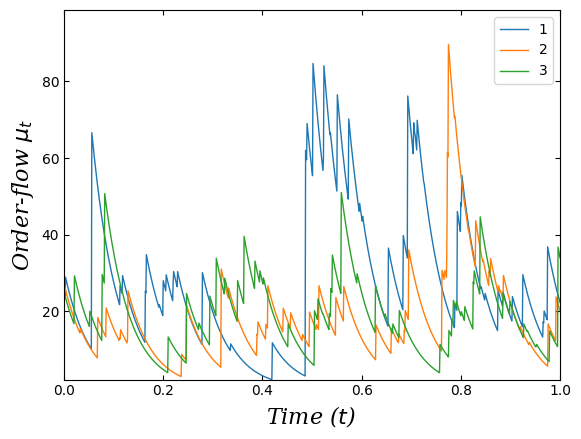

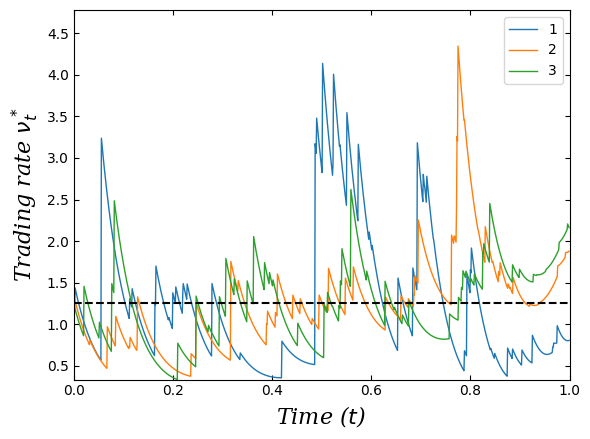

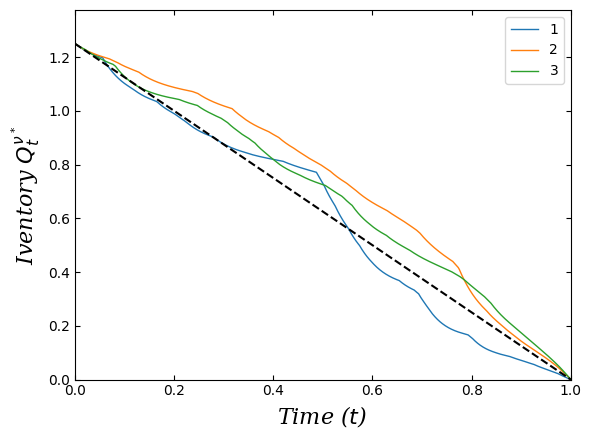

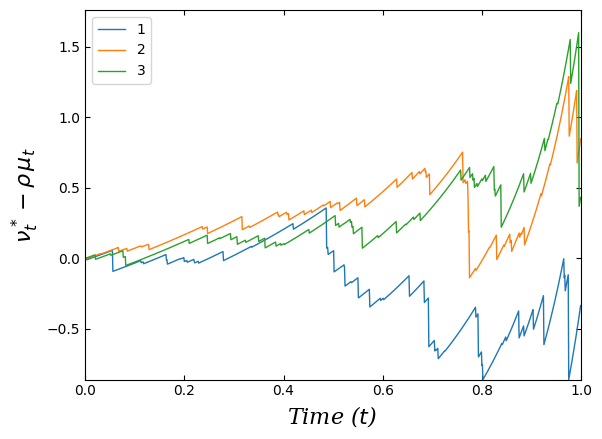

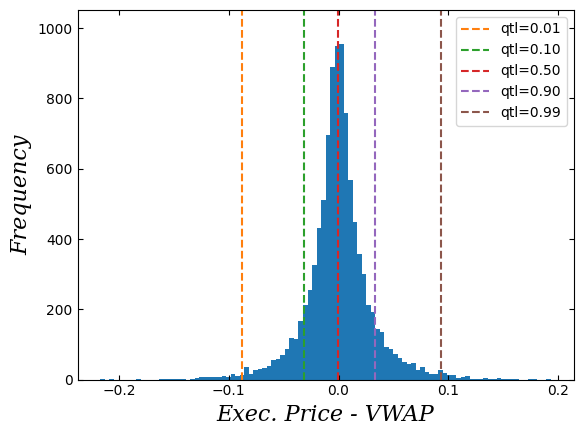

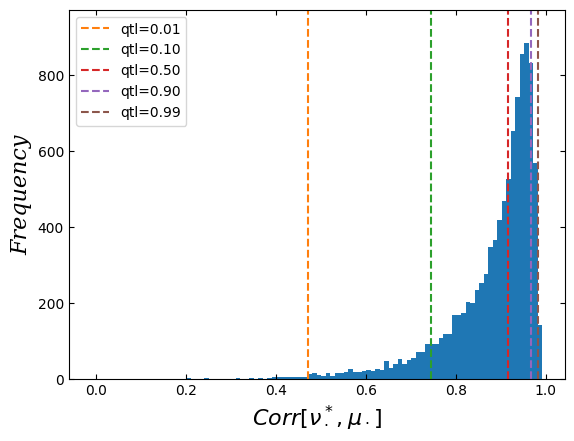

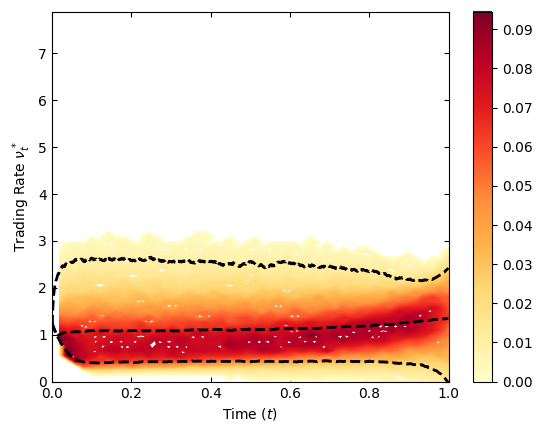

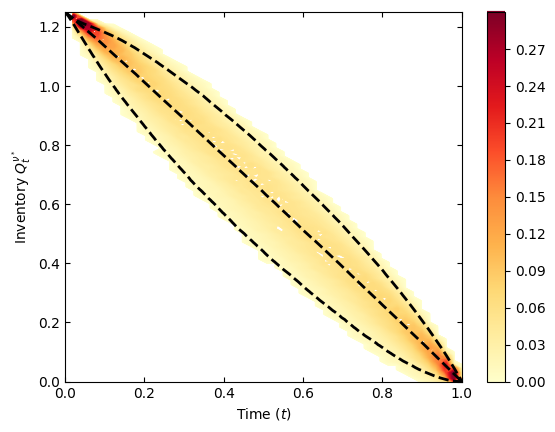

In [2]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
np.random.seed(30)
np.seterr(divide='ignore', invalid='ignore')
font = {'family': 'serif',
        'style': 'italic',
        # 'color': 'darkred',
        'weight': 1,
        'size': 16,
        }


# Time grid
T = 1  # Expiry
Ndt = 1000  # Number of time increments
dt = T/Ndt  # Time change increment
t = np.arange(0, T+0.000001, dt)  # Time increments vector 

# Market Impact and Aversionn Parameters
k = 0.1  # Temporary Market Impact
rho = 0.05  # Target fraction of market speed
b = 0.1  # Permanent Price Impact Factor

# Price Variables
S0 = 20  # Initial Midprice
sigma = 0.5  # Volatilty (recall this is an artihmetic model)

# Volume Rate
eta = 10  # Jump Size (Exponential Jump Size)
lam = 50  # Rate of Arrival of Jumps (Poisson Process)
kappa = 20  # Rate of Mean-Reversion

psi = eta*lam/kappa  #

Nsims = 10000  # Number of Simulations

idxfig = [0,1,2] # Index of path to be plotted

# Initializing variables for simulation base on computed strategy

mu = np.full([Nsims, Ndt+1], np.nan)  # Trade Speed Matrix for Maket
S = np.full([Nsims, Ndt + 1], np.nan)  # Midprice Matrix
Vwap = np.full([Nsims, Ndt + 1], np.nan)  # Volume Weighted Average Price Matrix
Y = np.full([Nsims, Ndt + 1], np.nan)  # Accumulated Transaction Matrix
V = np.full([Nsims, Ndt + 1], np.nan)  # Traded Volume Matrix
S_hat = np.full([Nsims, Ndt+1], np.nan)  # Execution Price Matrix
Q = np.full([Nsims, Ndt + 1], np.nan)  # Inventory Matrix
X = np.full([Nsims, Ndt + 1], np.nan)  # Strategy Cost Matrix
nu = np.full([Nsims, Ndt + 1], np.nan)  # Optimal Liquidation Speed Matrix
corr_mat = np.full([Nsims, 1], np.nan)  # Market Trade Speed VS Liquidation Speed Correlation Matrix  

# Initial conditions
mu[:,0] = psi  # Setting Initial Market Trade Speed
S[:,0] = S0  # Setting Initial Midprice
Vwap[:,0] = S0  # Setting Initial Vwap
Y[:,0] = 0  # Setting Initial Accumulated Transactions
V[:,0] = 0  # Setting Initial Trade Volume
Q[:,0] = psi*rho*T  # Setting Initial Inventory
X[:,0] = 0  # Setting Initial Strategy Cost

for m in range(Ndt):

    # Time Remaining until Expiration
    tau = T-t[m]
        
    # Determine optimal liquidation speed
    A = (1-np.exp(-kappa*tau))/kappa
    B = (A*(mu[:,m]-psi) + tau*psi )/ (tau)
    
    nu[:,m] = rho*(mu[:,m] - B) + Q[:,m]/(tau)


    # determine execution Price
    S_hat[:,m] = S[:,m] - k * nu[:,m]*dt
      
    # Update Inventory and Cash Process
    X[:,m+1] = X[:,m] + np.multiply( S_hat[:,m], nu[:,m]*dt )
    Q[:,m+1] = Q[:,m] - nu[:,m]*dt

    
    # Update VWAP
    Y[:,m+1] = Y[:,m] + np.multiply(S[:,m], mu[:,m]) * dt
    V[:,m+1] = V[:,m] + mu[:,m] * dt
    Vwap[:,m+1] = np.divide(Y[:,m+1],V[:,m+1])
    
    # Update Midprice
    S[:,m+1] = S[:,m] + b*nu[:,m] * dt + (sigma*np.random.randn(Nsims,1)*(dt**0.5)).reshape(Nsims)
    
    # Update Other Agent's Trading Rates
    dN = [np.random.rand(Nsims,1) < (1-np.exp(-lam*dt))]
    etaSim = -eta*np.log(np.random.rand(Nsims,1))
    mu[:,m+1] = mu[:,m]*np.exp(-kappa*dt) + np.multiply(etaSim, dN).reshape(Nsims)

# Calculation the correlation between Market Trade Speed and Liquidation Speed
for i in range(Nsims):
    corr_mat[i] = np.corrcoef(nu[i,:-2], mu[i,:-2])[1,0]
    
# Visualizing results 
PlotPath(t, T, mu, idxfig, "Order-flow $\mu_t$", lw=1)
PlotPath(t, T, nu, idxfig, "Trading rate " + r"$\nu^*_t$", lw=1, midline=[0, np.full(t.shape, Q[0,0]/T)])
PlotPath(t, T, Q, idxfig, r"Iventory " + r"$Q^{\nu^*}_t$", lw=1, midline=[0,Q[0,0]*(1-t/T)])
PlotPath(t, T, nu - rho*mu, idxfig, r"$\nu^*_t-\rho\,\mu_t$", lw=1)

# Visualizing difference between cost per share and VWAP
PlotHist(X[:,-1]/Q[0,0] - Vwap[:,-1], 'Exec. Price - VWAP', bins=100)
# Visualizing the correlation matrix
PlotHist(corr_mat, r'$Corr[\nu^*_\cdot,\mu_\cdot]$', bins=100)

# Visualizing density plot of simulations
MakeHeatMap(t, nu, r'Time ($t$)', r'Trading Rate $\nu_t^*$', 11, 100, 100, 50, 0.01,0.2)
MakeHeatMap(t, Q, r'Time ($t$)', r'Inventory $Q_t^{\nu^*}$', 10, 100, 100, 50, 0.01,0.3)

# Percentage of cumulative volume 
We assume that the agent's execution strategy targets a percentage of cumulative volume and the liquidation strategy relies on MOs. The accumulated volume V of sell orders is $V_{t} = \int_{0}^{t} \mu_{u} du$

$V_{t}^{*} = \frac{1}{2k} [h_{1}(t, \mu_{t}, v_{t}) + 2 (h_{2}(t) + \frac{1}{2}b)Q_{t}^{v^{*}}]$

The optimal speed of trading can be decomposed in two terms. The second term is similar to the AC like solution where the penalty on deviations from POCS plays the same role as the urgency parameter in the AC like setting. The first term adjusts the strategy to account for the rate and volume of trades up to that point in time.

- Compound Poisson Model of volume : As said before, a reasonable first order model is one where traded volume comes in burst of activity which perists for a while and then decays to zero. Here we model volume of trades as a market point process $V_{t} = \sum_{n=1}^{N_{t} n_{n}}$
- Stochastic Mean-Reverting volume rate : Recall that the cumulative volume of other market participant's trades on the sell side of the market is given by $V_{t} = \int_{0}^{t} \mu_{u} du$ and $d\mu{t} = -k \mu_{t}
 dt + n_{t} dN_{t}$

# Including Impact of other traders

We assume that MOs form all market participants, including the agen'ts have permanent effect on the midprice as shown by  $dS_{t}^{v} = b (\mu_{t}^{+} - (v_{t} + \mu_{t}^{-})) dt + \sigma dW_{t}$ with $\mu_{t}^{+}$ (buy) and $\mu_{t}^{-}$ and $v_{t}$ is the agent's liquidation rate, which would be added to the drift and not substracted if the agent was buying. As before  the agent's execution price is assumed to be linear in his trading rate.

$V_{t}^{*} = \frac{Q_{t}^{v^{*}}}{(T-t) + \zeta} + \frac{\phi}{\phi + k} \rho (\mu_{t} - \frac{\int_{t}^{T} E[\mu_s | F_{t}^{u}] ds}{(T-t)+ \zeta}) - \frac{b}{k+\phi} \frac{\int_{t}^{T} ((T-s)+\zeta)E[\mu_s | F_{t}^{u}] ds}{(T-t)+ \zeta}$

To understand the functioning of the liquidation strategy we see that the first two terms are identical to the case which does not account for the impact of other traders. The third term act to correct the agent's trading based on his expectation on the net order flow from that point in time until the end of the trading horizon. When there is no imbalance ($\mu_{t}^{+} = \mu_{t}^{-}$) the liquidation rate is as before. When there is a surplus of buy trades, however the agents slow down his trading rate to allow the midprice to appreciate before liquidating the rest of order. When there is a surplus of sell orders, he speed up the trades for two reasons (i) because he must match the POV on the sell side, and (ii) the action of other sellers in the market will push prices downwards and therefore the profit.

# Utility maximiser

The agent's objective is to maximise expected utility oof terminal wealth but also targe POV. To solve the problem we have to consider what is sometimes ccalled a recursive intertemporally additive penalty. The solution is that is there is a lot of value at a point in time in the state spacce, the agent is averse to moving away from POV, while if there is little value at that point in statespace, the agent is willing to deviate from POV if it give him value.